<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Naive Bayes Language Detection Lab
---

In this lab, we will use Naive Bayes (and other classifiers) to auto-detect the language of a given tweet. We will then assess the performance of our classifier.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
sns.set(font_scale=1.5)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [3]:
tweets_df = pd.read_csv("../datasets/tweets_language.csv")
tweets_df.drop([tweets_df.columns[0]], axis=1, inplace=True)
# By default, everything read in is a string!
tweets_df.index = tweets_df.index.astype(int)

In [4]:
tweets_df.head()

,LANG,TEXT
0,en,The #Yolo bailout: Greece's ex-finance chief h...
1,en,Another mental Saturday night. It will be near...
2,en,Sometimes you take bedtime selfies w yer hat s...
3,en,Currently just changed my entire outfit includ...
4,en,I just like listening to @SpotifyAU's top 100 ...


In [5]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9431 entries, 0 to 9430
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   LANG    9409 non-null   object
 1   TEXT    9409 non-null   object
dtypes: object(2)
memory usage: 147.5+ KB


In [6]:
# Note above that some rows are null, which we cannot use for training
tweets_df = tweets_df.dropna()

In [7]:
tweets_df.head()

,LANG,TEXT
0,en,The #Yolo bailout: Greece's ex-finance chief h...
1,en,Another mental Saturday night. It will be near...
2,en,Sometimes you take bedtime selfies w yer hat s...
3,en,Currently just changed my entire outfit includ...
4,en,I just like listening to @SpotifyAU's top 100 ...


In [8]:
tweets_df.shape

(9409, 2)

### 1. Data exploration

#### 1.A. Explore a list of tweet words that occur more than 50x
Plotting a histogram of some kind might be helpful.

In [9]:
# Let's use the CountVectorizer to count words for us
cvec = CountVectorizer(strip_accents='unicode', ngram_range=(1, 1))
X_all = cvec.fit_transform(tweets_df['TEXT'])
columns = cvec.get_feature_names()

# note this is a large sparse matrix.
#    - rows are tweets, columns are words
X_all

<9409x32951 sparse matrix of type '<class 'numpy.int64'>'
	with 130566 stored elements in Compressed Sparse Row format>

In [10]:
# Converting X_all toarray() may use too much memory (particularly for 32-bit Python!)
print(X_all.shape)
print("Requires {} ints to do a .toarray()!".format(np.prod(X_all.shape))
      )
# x_df     =  pd.DataFrame(X_all.toarray(), columns=columns)
# tf_df    =  pd.DataFrame(x_df.sum(), columns=["freq"])
# tf_df.sort_values("freq", ascending=False).head(10)

(9409, 32951)
Requires 310035959 ints to do a .toarray()!


In [11]:
# So .. we'll use np.sum() to convert it directly from the sparse matrix!
# This is enormously more memory-efficient ...
#   It only requires one int per column since summing across columns is the total word count.


def get_freq_words(sparse_counts, columns):

    # X_all is a sparse matrix, so sum() returns a 'matrix' datatype ...
    #   which we then convert into a 1-D ndarray for sorting

    word_counts = np.ravel(X_all.sum(axis=0))
    freq_words = pd.Series(
        word_counts, index=columns).sort_values(ascending=False)

    return freq_words


freq_words = get_freq_words(X_all, columns)
freq_words[:20]

co        8544
http      6093
https     2658
rt        2222
love      1758
dog       1219
family    1082
france    1032
de         984
us         951
da         889
peace      811
yolo       742
la         723
earth      702
in         604
the        598
planet     589
math       473
en         425
dtype: int64

- Note above that many of the most common words actually may not be relevant to determining language!
- Also, we are removing important features such as capitalization, punctuation, sentence length, etc. that might be important for determining language.

#### 1.B. Investigate histogram of counts

In [12]:
def hist_counts(series, bins=np.logspace(0, 4, 20), density=True):

    fig, ax = plt.subplots(figsize=(8, 4))
    series.hist(bins=bins, ax=ax, density=density)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title('Word count distribution')

    return fig, ax

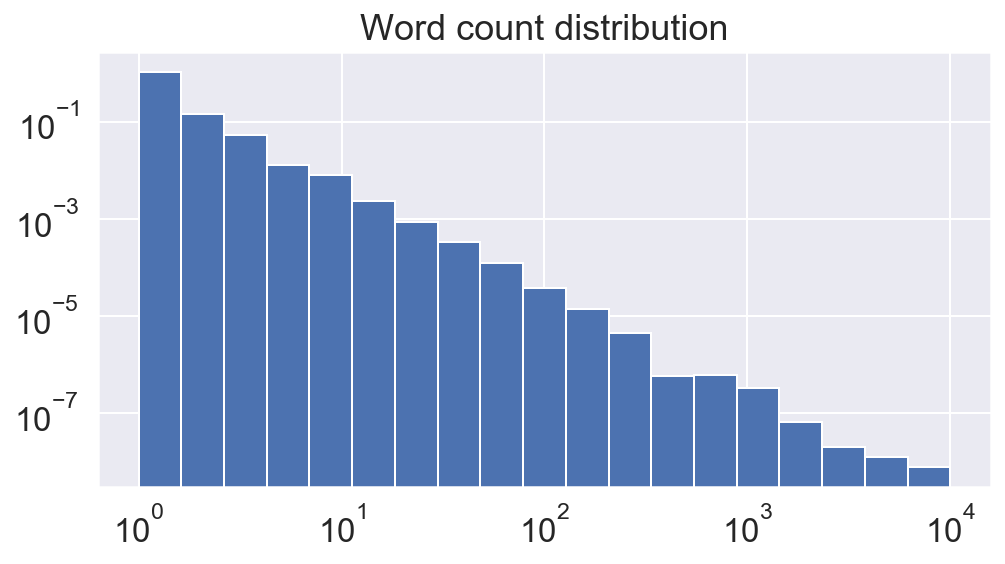

In [13]:
fig, ax = hist_counts(freq_words)

#### 1.C. Try it again with stopword removal 

http      6093
https     2658
rt        2222
love      1758
dog       1219
family    1082
france    1032
da         889
peace      811
yolo       742
dtype: int64


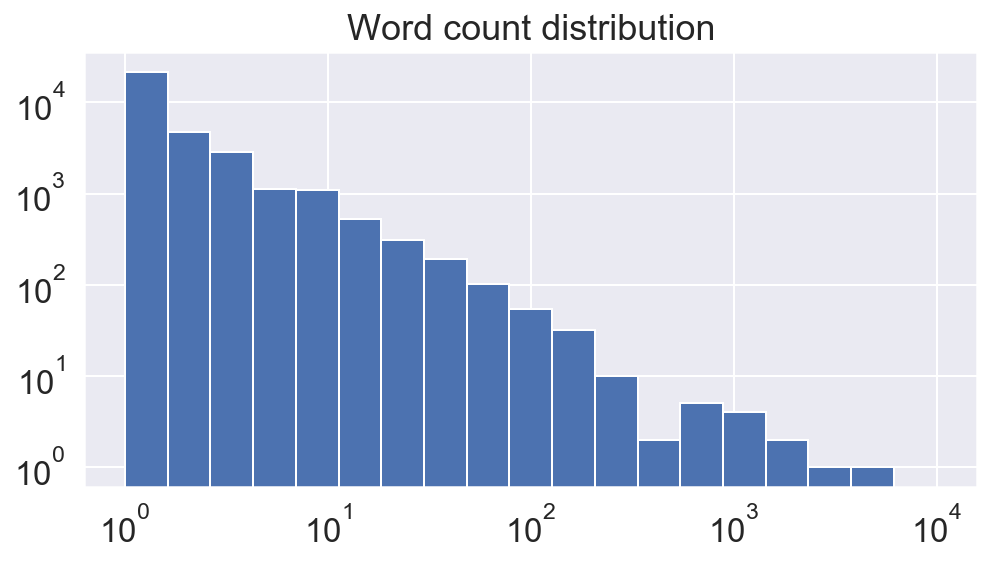

In [14]:
cvec = CountVectorizer(strip_accents='unicode',
                       stop_words="english", 
                       ngram_range=(1, 1))

X_all = cvec.fit_transform(tweets_df['TEXT'])
columns = cvec.get_feature_names()

freq_words = get_freq_words(X_all, columns)

print(freq_words[:10])
fig, ax = hist_counts(freq_words, density=False)

#### 1.D. Explore ngrams between 2 and 4
Display the top 75 ngrams with frequencies.

In [15]:
cvec = CountVectorizer(stop_words="english", ngram_range=(2, 4))
X_all = cvec.fit_transform(tweets_df['TEXT'])
columns = cvec.get_feature_names()

freq_words = get_freq_words(X_all, columns)
freq_words[:75]

france http                         193
naturevalley planet                 193
da http                             173
love https                          155
silver junksilver                   151
                                   ... 
cuff injury recovery                 54
cuff injury recovery kit             54
earth nature                         54
les vacances                         54
hund hunde hundehalsband organic     53
Length: 75, dtype: int64

#### 1.E. (Optional) try expanding the list of stopwords
There are definitely some non-words such as web urls, etc. If you could remove them, this could help us improve the score.  Identify word/tokens that don't add much value to either class.  **You should additionally look at ngrams per language to fine tune your preprocessing.  This has the greatest potential to improve your results without tuning any model parameters.**

Using `nltk.corpus`, we can get a baseline list of stop words.  Try to expand it and pass it to our vectorizer.

In [16]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
stop += ['http', 'https', 'rt']

In [17]:
# These look pretty clean for a first step in anlaysis
cvec = CountVectorizer(stop_words=stop, lowercase=True,
                       strip_accents="unicode", ngram_range=(1, 2))
X_all = cvec.fit_transform(tweets_df['TEXT'])
columns = cvec.get_feature_names()

freq_words = get_freq_words(X_all, columns)
freq_words[:20]

co        8544
love      1758
dog       1219
family    1082
france    1032
de         984
us         951
da         889
peace      811
yolo       742
la         723
earth      702
planet     589
math       473
en         425
hund       333
que        332
vive       307
un         304
silver     304
dtype: int64

### 2. Setup a test / train split of your data using any method you wish.
Try 70/30 to start.

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
tweets_train, tweets_test = train_test_split(tweets_df,
                                             test_size=0.3,
                                             stratify=tweets_df['LANG'],
                                             random_state=1)

In [20]:
tweets_train.shape[0], tweets_test.shape[0]

(6586, 2823)

### 3. Setup a "Pipeline" to vectorize and use MultinomialNB classifier.
Use `lowercase`, `strip_accents`, `Pipeline`, and optionally your updated `stop_words`.  Fit your comment data using the "Insult" feature as your response.

Fit your training data to your pipeline, then score it.

In [21]:
cvec = CountVectorizer(
    lowercase=True, strip_accents='unicode', stop_words=stop)

# MultinomialNB
pipeline = Pipeline([
    ('vect', CountVectorizer(lowercase=True, strip_accents='unicode', stop_words=stop)),
    ('tfidf', TfidfTransformer()),
    ('cls', MultinomialNB())
])
pipeline.fit(tweets_train["TEXT"], tweets_train["LANG"])
predicted = pipeline.predict(tweets_test["TEXT"])
pipeline.score(tweets_test["TEXT"], tweets_test["LANG"])

0.7219270279844138

In [22]:
# Alternative -- train on count vectorized data
# MultinomialNB
pipeline = Pipeline([
    ('vect', cvec),
    # ('tfidf', TfidfTransformer()),
    ('cls', MultinomialNB())
])
pipeline.fit(tweets_train["TEXT"], tweets_train["LANG"])
predicted = pipeline.predict(tweets_test["TEXT"])
pipeline.score(tweets_test["TEXT"], tweets_test["LANG"])

0.753099539496989

#### 3.A. Swap out MultinomialNB with BernoulliNB in the pipeline
How do they compare? Do you have a guess of why BernoulliNB is so poor?

In [23]:
# BernoulliNB
pipeline = Pipeline([
    ('vect', cvec),
    ('cls', BernoulliNB())
])
pipeline.fit(tweets_train["TEXT"], tweets_train["LANG"])
predicted = pipeline.predict(tweets_test["TEXT"])
pipeline.score(tweets_test["TEXT"], tweets_test["LANG"])

0.5108041091037903

#### 3.B. Also try logistic regression and random forests in the pipeline
How do they compare? Recall that Logistic Regression is discriminative whereas Naive Bayes is generative. Logistic Regression uses optimization to fit a formula that discriminates between the classes, whereas Naive Bayes essentially just computes aggregate statistics. So, Logistic Regression should have a longer training time than Naive Bayes -- does it here? (see `%time`)

Note that Logistic Regression and Random Forests both allow you to see feature "importance"/coefficients. In this case, these coefficients will inform you how strong each word indicates a language. Optionally, see if you can sort these coefficients by their values to get the strongest and weakest indicator words for languages.

In [24]:
# LogisticRegression
pipeline = Pipeline([
    ('vect', cvec),
    #('tfidf', TfidfTransformer()),
    ('cls', LogisticRegression(solver='lbfgs', multi_class='ovr'))
])
pipeline.fit(tweets_train["TEXT"], tweets_train["LANG"])
predicted = pipeline.predict(tweets_test["TEXT"])
pipeline.score(tweets_test["TEXT"], tweets_test["LANG"])

0.7651434643995749

In [25]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [26]:
# Random Forest
pipeline = Pipeline([
    ('vect', cvec),
    #('tfidf', TfidfTransformer()),
    ('cls', RandomForestClassifier(n_estimators=200))
])
pipeline.fit(tweets_train["TEXT"], tweets_train["LANG"])
predicted = pipeline.predict(tweets_test["TEXT"])
pipeline.score(tweets_test["TEXT"], tweets_test["LANG"])

0.7272405242649663

In [27]:
# Gradient Boosting
pipeline = Pipeline([
    ('vect', cvec),
    #('tfidf', TfidfTransformer()),
    ('cls', GradientBoostingClassifier(n_estimators=200))
])
pipeline.fit(tweets_train["TEXT"], tweets_train["LANG"])
predicted = pipeline.predict(tweets_test["TEXT"])
pipeline.score(tweets_test["TEXT"], tweets_test["LANG"])

0.720510095642933

#### 3.C. Also try tweaking the paramters of CountVectorizer and TfidfTranformer

Remove Tfidf also. Good / bad?

In [28]:
# BernoulliNB
cvec_1 = CountVectorizer(stop_words=stop, lowercase=True,
                         strip_accents="unicode", ngram_range=(1, 2))
pipeline = Pipeline([
    ('vect', cvec_1),
    #('tfidf', TfidfTransformer()),
    ('cls', LogisticRegression(solver='lbfgs', multi_class='ovr'))
])
pipeline.fit(tweets_train["TEXT"], tweets_train["LANG"])
predicted = pipeline.predict(tweets_test["TEXT"])
pipeline.score(tweets_test["TEXT"], tweets_test["LANG"])

0.7662061636556854

### 4. Check your score.
Which languages does your model work best at? Run a classification report for all languages. Plot AUC/ROC for particular languages (vs all others) and compare them -- do they show that some languages perform better? Does our model perform worse than guessing on some languages? 

In [29]:
from sklearn.metrics import confusion_matrix

In [30]:
predicted = pipeline.predict(tweets_test["TEXT"])
probabilities = pipeline.predict_proba(tweets_test['TEXT'])

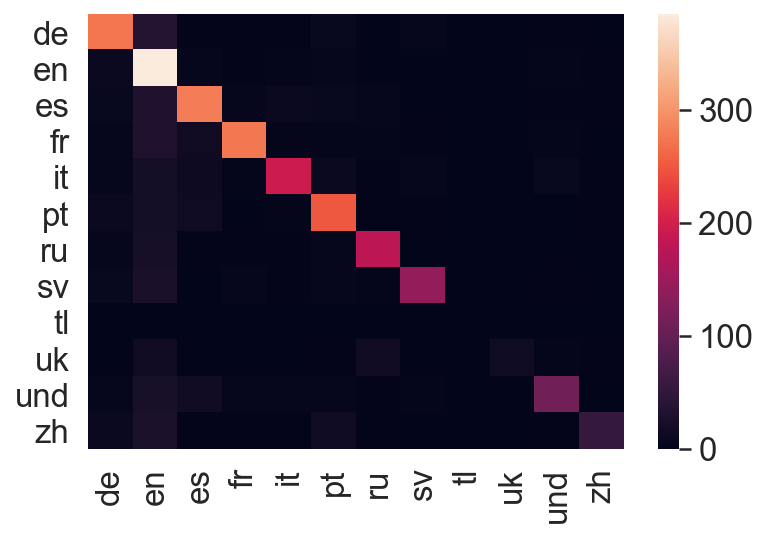

In [31]:
sns.heatmap(confusion_matrix(tweets_test.LANG, predicted, labels=pipeline.classes_),
            yticklabels=pipeline.classes_,
            xticklabels=pipeline.classes_)
plt.show()

In [32]:
print(classification_report(tweets_test["LANG"], predicted))

              precision    recall  f1-score   support

          de       0.79      0.82      0.81       334
          en       0.59      0.92      0.72       420
          es       0.79      0.79      0.79       354
          fr       0.90      0.80      0.84       347
          it       0.84      0.72      0.77       269
          pt       0.78      0.81      0.80       309
          ru       0.82      0.81      0.81       223
          sv       0.86      0.71      0.78       202
          tl       0.00      0.00      0.00         1
          uk       0.88      0.24      0.38        58
         und       0.77      0.61      0.68       185
          zh       0.78      0.44      0.56       121

    accuracy                           0.77      2823
   macro avg       0.73      0.64      0.66      2823
weighted avg       0.79      0.77      0.76      2823



/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
import scikitplot as skplt
from matplotlib.colors import ListedColormap
cmap = ListedColormap(sns.color_palette(
    "husl", len(tweets_test['LANG'].unique())))

In [34]:
def plot_f1_lines(figsize=(8, 6), fontsize=16):
    '''Create f1-score level lines to be added to the precison-recall plot'''

    fig, ax = plt.subplots(figsize=figsize)

    # add lines of constant F1 scores

    for const in np.linspace(0.2, 0.9, 8):
        x_vals = np.linspace(0.001, 0.999, 100)
        y_vals = 1./(2./const-1./x_vals)
        ax.plot(x_vals[y_vals > 0], y_vals[y_vals > 0],
                color='lightblue', ls='--', alpha=0.9)
        ax.set_ylim([0, 1])
        ax.annotate('f1={0:0.1f}'.format(const),
                    xy=(x_vals[-10], y_vals[-2]+0.0), fontsize=fontsize)

    return fig, ax

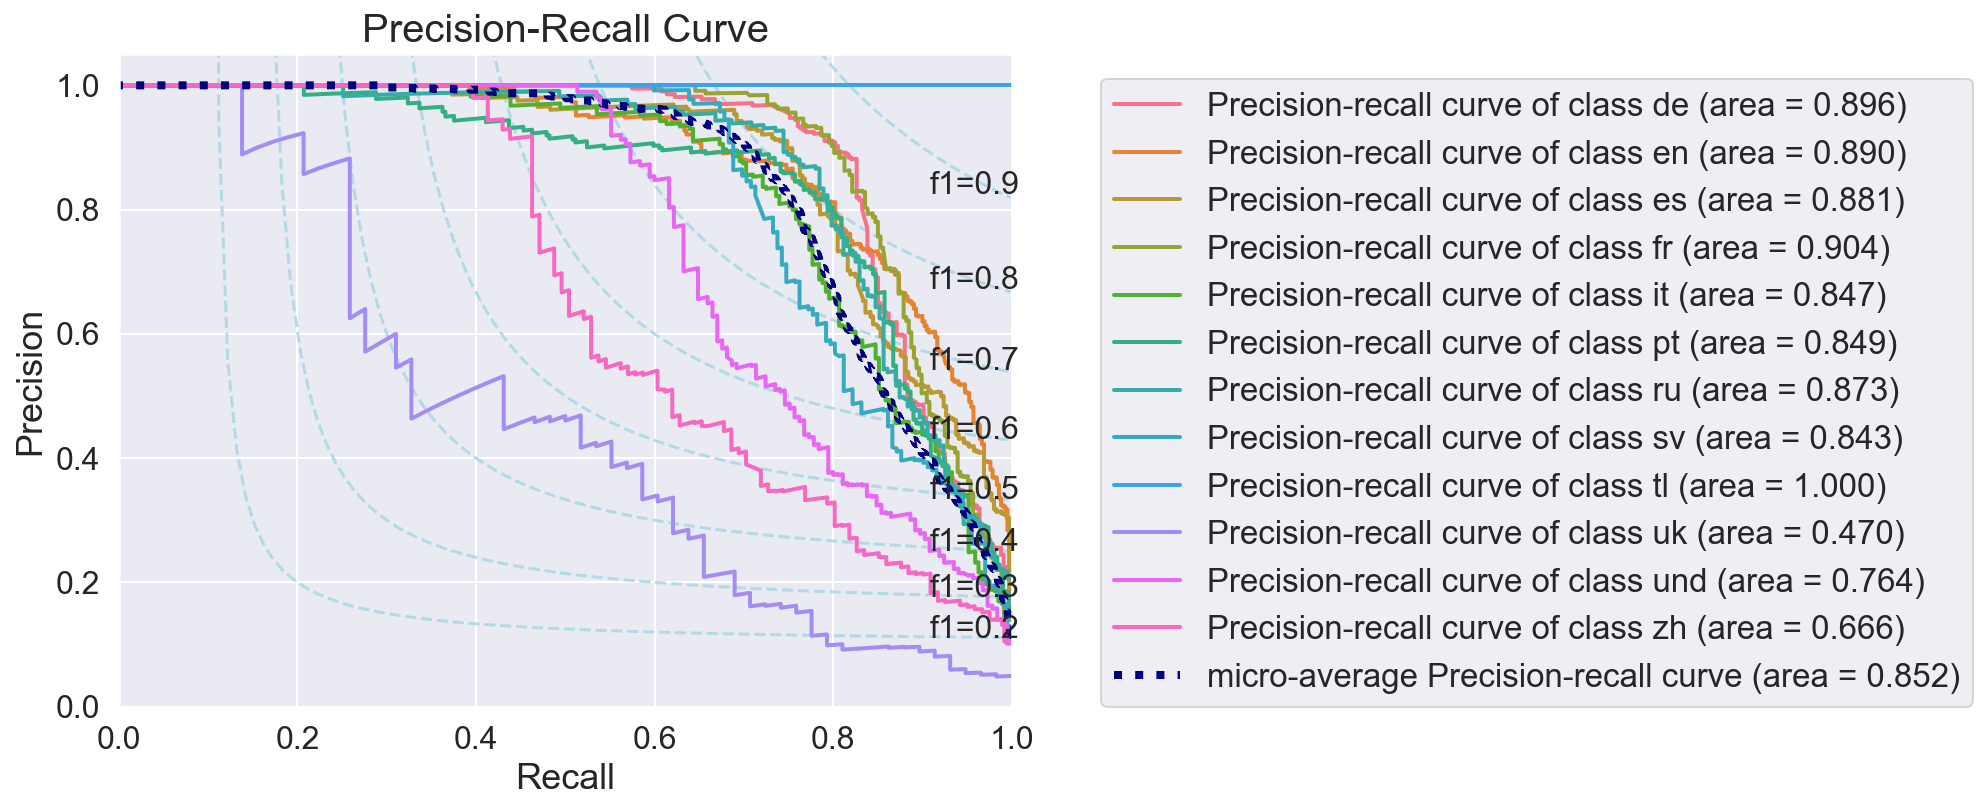

In [35]:
fig, ax = plot_f1_lines()
skplt.metrics.plot_precision_recall(tweets_test[['LANG']], probabilities,
                                    plot_micro=True,
                                    title_fontsize=20, text_fontsize=16,
                                    cmap=cmap,
                                    ax=ax
                                    )
ax.legend(loc=[1.1, 0])
plt.show()

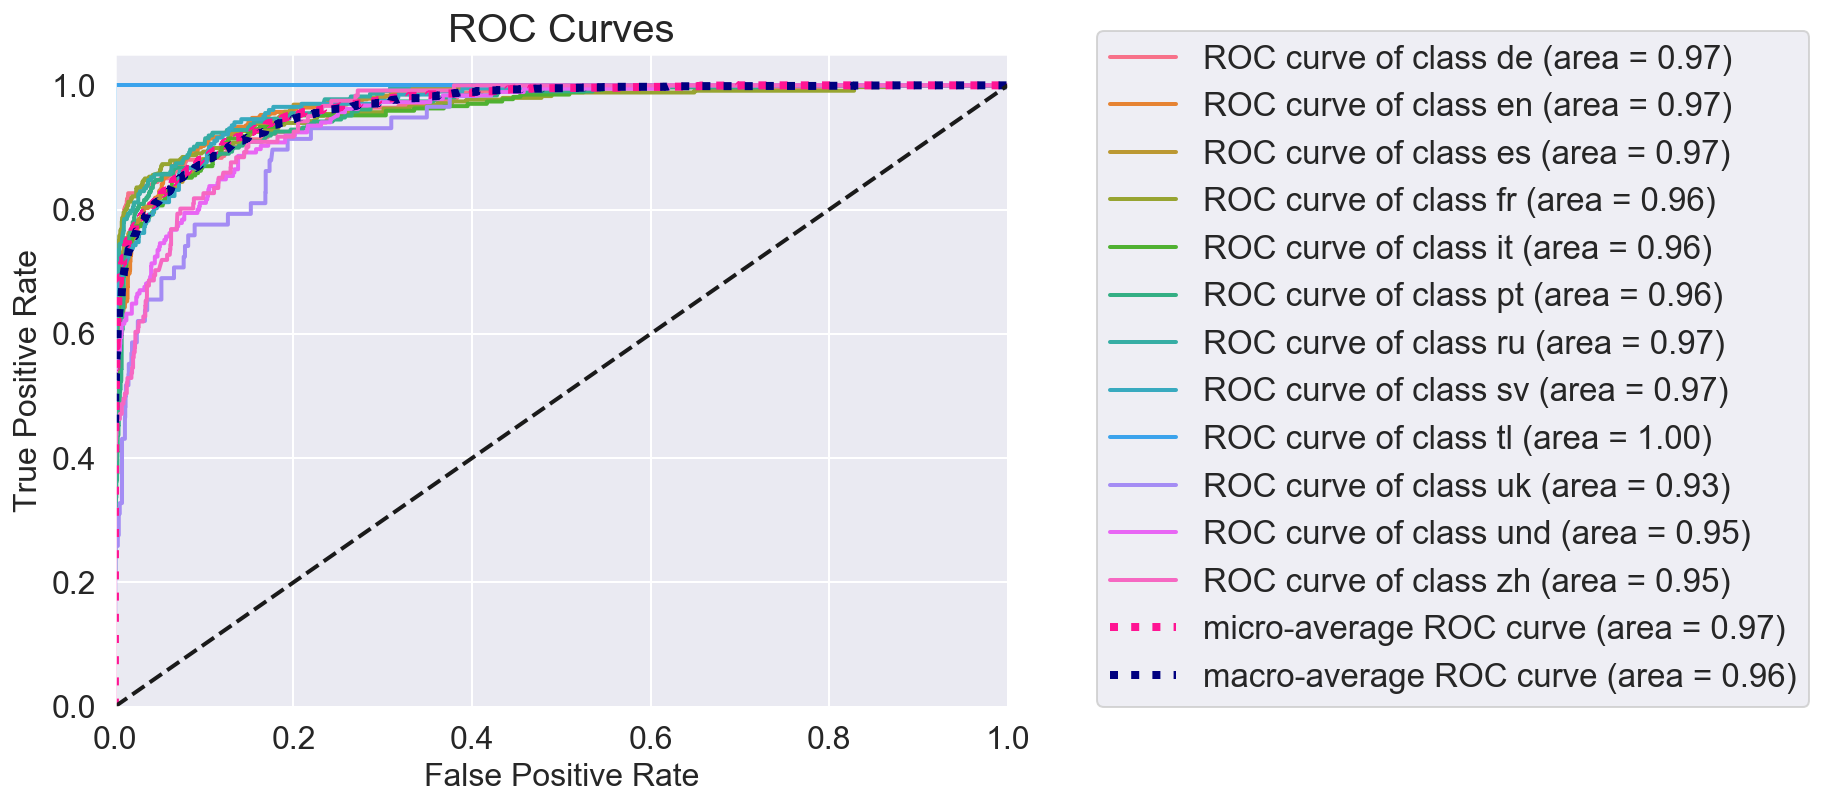

In [36]:
fig, ax = plt.subplots(figsize=(8, 6))
skplt.metrics.plot_roc(tweets_test[['LANG']], probabilities,
                       plot_micro=True, plot_macro=True,
                       title_fontsize=20, text_fontsize=16,
                       figsize=(8, 6), cmap=cmap, ax=ax)
ax.legend(loc=[1.1, 0])
plt.show()

### 5 Check out your baseline.

What is the chance that you will randomly guess correctly without any modeling? Assume the language of your input phrase has the same chance of appearing as the languages in your training set.

In [37]:
tweets_train.LANG.value_counts(normalize=True)

en     0.148800
es     0.125266
fr     0.122684
de     0.118129
pt     0.109475
it     0.095202
ru     0.079259
sv     0.071819
und    0.065442
zh     0.043122
uk     0.020346
tl     0.000456
Name: LANG, dtype: float64

In [38]:
tweets_train[tweets_train.LANG=='und'].loc[6356].values

array(['und',
       '#Rosario #ManuelBelgrano #Love #Family #Trip ❤️ juanamoscheni martumoscheni @marcelomoscheni https://t.co/Xp0WL0wbDA'],
      dtype=object)

### 6. What is your model not getting right?

Check out the incorrectly classified tweets.  Any noticable patterns? Can you explain why many of these are incorrectly classified, given what you know about how Naive Bayes works?  Pay particular attention to the recall metric.  What might be done in preprocessing steps to improve accuracy?  

- Try to improve with your **preprocessing first**
- THEN try to tweak your **parameters to your model(s)**

In [39]:
predicted = pipeline.predict(tweets_df["TEXT"])

# Incorrectly classified
incorrect_preds = tweets_df[(predicted != tweets_df['LANG'])]
incorrect_preds = (predicted != tweets_df['LANG'])

In [40]:
incorrect_preds.shape

(9409,)

In [41]:
incorrect_df = pd.DataFrame({'actual': tweets_df['LANG'],
                             'predicted': predicted,
                             'mismatch': incorrect_preds,
                             'TEXT': tweets_df.TEXT})

incorrect_df[incorrect_df.mismatch == True].head(10)

,actual,predicted,mismatch,TEXT
9,en,es,True,S W A G #withfilter #school #swag #cool #yolo ...
35,en,de,True,im painting my nails at 2:30am #yolo #yoloswag...
74,en,es,True,@vddfalcona because #yolo #swag #policiastem7b...
78,en,es,True,Stonehenge live #diaverde #vegan #friends #bro...
138,en,es,True,RT @VICOCENTENO: What beautiful place with my ...
239,en,it,True,RT @tagi_madi: Morgherini’s #Iran trip encoura...
295,en,it,True,RUSSIA SET TO REJECT #UNSC resolution to inves...
315,en,fr,True,Breathtaking Images of #Earth Shot from Lofty ...
460,en,de,True,#NatureValley #Planet Strayed ant http://t.co/...
462,en,de,True,#NatureValley #Planet Sunset at the beach in B...


In [42]:
print(incorrect_df[incorrect_df.mismatch == True])

     actual predicted  mismatch  \
9        en        es      True   
35       en        de      True   
74       en        es      True   
78       en        es      True   
138      en        es      True   
...     ...       ...       ...   
9371     it        fr      True   
9388     it        sv      True   
9399     it        sv      True   
9416     it        en      True   
9423     it       und      True   

                                                   TEXT  
9     S W A G #withfilter #school #swag #cool #yolo ...  
35    im painting my nails at 2:30am #yolo #yoloswag...  
74    @vddfalcona because #yolo #swag #policiastem7b...  
78    Stonehenge live #diaverde #vegan #friends #bro...  
138   RT @VICOCENTENO: What beautiful place with my ...  
...                                                 ...  
9371  @effellstyle le nostre cose belle a porto cerv...  
9388  vi porto a casa 🔥♥️\n\n @satamorte \n#family #...  
9399  Bas mirchi khata hai!\n#family  #instalike #in...  

In [43]:
incorrect_df[incorrect_df.mismatch == True].groupby(
    ['actual', 'predicted'])[['mismatch']].count()

mismatch
actual predicted          
de     en               37
       es                2
       fr                2
       it                2
       pt                8
...                    ...
zh     it                2
       pt               14
       ru                3
       sv                1
       und               3

[94 rows x 1 columns]

## Additional Practice
In the datasets directory are two additional datasets you can use for additional pratice:

- **/datasets/tweets_sentiment.csv** - Sentiment analysis

- **/datasets/insults_train.csv** - [Kaggle dataset](https://www.kaggle.com/c/detecting-insults-in-social-commentary). _WARNING:_ This content is fairly provacative and contains very offensive and insensitive words. However, this type of problem is very common in the continuum of comment threads throughout the web.

    - Check [this blog post](http://webmining.olariu.org/my-first-kaggle-competition-and-how-i-ranked/) by a guy who used SVM, a "neural network", a ton of cleaning, then placed 3rd in a Kaggle competition featuing this same dataset. Also see [this blog post](http://peekaboo-vision.blogspot.de/2012/09/recap-of-my-first-kaggle-competition.html) -- he got 6th place and found the best model was a simple Logistic Regression!

#### Where Next?

If you're interested in this type of problem, a great area to read up on is sentiment analysis.  This [Kaggle dataset](https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews/data) is an excellent opportunity to practice more.  Also these whitepapers are great places to expand on this topic:

- [Fast and accurate sentiment classification using an
enhanced Naive Bayes model](http://arxiv.org/pdf/1305.6143.pdf) *Great overview!*
- [Sarcasm Detection](http://www.aclweb.org/anthology/P15-2124)
- [Making Computers Laugh:
Investigations in Automatic Humor Recognition](http://www.aclweb.org/anthology/H05-1067)
- [Modelling Sarcasm in Twitter, a Novel Approach](http://www.aclweb.org/anthology/W14-2609)
- [RUNNING HEAD: NARCISSISM AND LIE DETECTION](https://deepblue.lib.umich.edu/bitstream/handle/2027.42/107345/zarins.finalthesis.pdf?sequence=1) *The study metrics are interesting*